In [7]:
import os
import re
import chardet

# 文件批处理
def FileReader(tag):
    # print(os.getcwd())
    path = r'./data/htl_del_4000/' + tag 
    os.listdir(path)
    FileList = []
    for iter in os.listdir(path):
        if os.path.splitext(iter)[1] == '.txt':
            FileList.append(iter)
    return FileList


In [8]:
# 对语料进行分词，去除停用词
import jieba
import json
import re
def _PreProcess(centence):
    centence = re.sub('\\s','',centence)
    centence = re.sub('[a-z,A-Z]*','',centence)
    
    row_list =  jieba.lcut(centence,cut_all = False)
    # print(row_list)
    return StripWord(row_list)
def StripWord(text):
    stop = open(r'./data/cn_stopwords.txt', 'r+', encoding='utf-8')
    
    tmp = stop.readlines()
    tmp = ''.join(tmp)
    stopWord = tmp.split("\n")
    # print(stopWord[:100])
    ans = []
    for iter in text:
        if not iter in stopWord:
            # print(iter)
            ans.append(iter)
    return ans
def PreProcess(path):
    text = ''
    # print(path)
    with open(path,'r',encoding = 'gbk',errors = 'ignore') as txt:
        text = txt.readline()
    # print(text[:20])
    return _PreProcess(text)


def File_Dic(FileList,tag):
    path = r'./data/htl_del_4000/' + tag + r'/'
    dic = {}
    for iter in range(0,len(FileList)):
        cur_path = path + FileList[iter]
        dic[iter] = PreProcess(cur_path)
        # print(dic[iter])
    return dic


def row_split(tag):
    FileList = FileReader(tag)
    # ReWrite(FileList,tag)
    volc = File_Dic(FileList,tag)
    # print(len(FileList))
    j_data = json.dumps(volc,ensure_ascii=False)
    with open(r'./row_语料分词_' + tag + '.json' ,'w',encoding='utf-8') as f:
        f.write(j_data)

row_split('pos')
row_split('neg')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Windows\Temp\jieba.cache
Loading model cost 0.632 seconds.
Prefix dict has been built successfully.


In [9]:
# 构建词表
def vocabulary(path):
    vocab = {}
    ans = {}
    with open(path,'r',encoding='utf-8') as f:
        vocab = json.load(f)

    for iter in vocab.keys():
        ans = set(ans)|set(vocab[iter])
    return ans

def Construct_vocabu(Path,tag):
    vocab = vocabulary(Path)
    with open(r'词表_'+tag,'w',encoding = 'utf-8') as f:
        for iter in vocab:
            f.write(iter + '\n')

Construct_vocabu(r'./row_语料分词_neg.json','neg')
Construct_vocabu(r'./row_语料分词_pos.json','pos')


In [10]:
# 总词表
def merge_vocab(Path_pos,Path_neg):
    pos = []
    neg = []
    with open(Path_pos,'r',encoding='utf-8') as f:
        pos = f.read().split('\n')
    with open(Path_neg,'r',encoding='utf-8') as f:
        neg = f.read().split('\n')
    return set(pos)|set(neg)

Merged_vocab = merge_vocab(r'./词表_pos',r'./词表_neg')

with open(r'./词表_Merged','w',encoding='utf-8') as f:
    for iter in Merged_vocab:
        f.write(iter + '\n')


In [11]:
# 统计文档频率
import json
def _Frequency(File_vocab,tag_vocab):
    dic = {}
    for iter in tag_vocab:
        count = 0
        for f in File_vocab.values():
            if iter in f:
                count += 1
        dic[iter] = count
    return dic
def Frequency(File_Vocab_Path,Tag_Vocab_Path,tag):
    File_vocab = {}
    tag_vocab = []
    with open(File_Vocab_Path,'r',encoding='utf-8') as f:
        print()
        File_vocab = json.load(f)
    with open(Tag_Vocab_Path,'r',encoding='utf-8') as f:
        tag_vocab = f.read()
        tag_vocab = tag_vocab.split('\n')
    
    dic = _Frequency(File_vocab,tag_vocab)
    j_data = json.dumps(dic,ensure_ascii=False)
    with open(r'./文档频率统计_' + tag + '.json','w',encoding = 'utf-8') as f:
        f.write(j_data)
    return
def cal_Frequency(tag):
    # print(r'./row_语料分词_'+tag +'.json')
    Frequency(r'./row_语料分词_'+tag +'.json',r'./词表_Merged',tag)

# dic1 = {'0':'[a,b,c]','1':'[d]'}
# l = ['a','b','c']
# ans = _Frequency(dic1,l)
# print(type(ans))

cal_Frequency('pos')
cal_Frequency('neg')
   

In [12]:
def merge_Frequenc(Path_pos,Path_neg):
    pos = {}
    neg = {}
    with open(Path_pos,'r',encoding = 'utf-8') as f:
        pos = json.load(f)
    with open(Path_neg,'r',encoding = 'utf-8') as f:
        neg = json.load(f)
    for iter in pos.keys():
        neg[iter] += pos[iter]
    return neg

Merged_Frequ = merge_Frequenc(r'./文档频率统计_pos.json',r'./文档频率统计_neg.json')

with open('./文档频率统计_merged.json','w',encoding = 'utf-8') as f:
    tmp = json.dumps(Merged_Frequ,ensure_ascii=False)
    f.write(tmp)

[ 200  201  201  202  204  205  209  212  220  231  231  232  244  245
  250  253  254  254  260  263  263  265  277  285  300  309  310  354
  379  391  393  403  413  418  468  490  524  526  548  551  606  632
  689  766  820 1001 1012 1045 1870 2024]
(15075,)


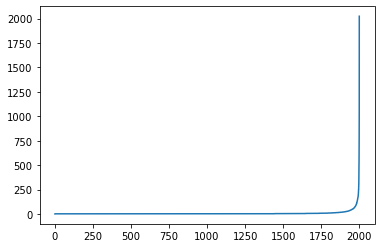

2024
0
15075


In [13]:
# 使用文档频率计算特征得分
# 归一化看一下频率分布
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
def _Frequency_distribute(freq):
    
    xpoints = np.arange(0,2000,2000/len(freq))
    # print(np.shape(xpoints))
    ypoints = np.array(freq)
    print(np.shape(ypoints))

    plt.plot(xpoints, ypoints)
    plt.show()

def Frequency_distribute(Path):
    data = {}
    with open(Path,'r',encoding='utf-8') as f:
        data = json.load(f)
    data_list = np.array(list(data.values()))
    data_list.sort()

    Max = data_list[-1]
    Min = data_list[0]
    print(data_list[-50:])
    # Data_list = []
    # for iter in data_list:
    #     Data_list.append(float((iter - Min))/float((Max - Min)))
    
    _Frequency_distribute(data_list)
    return Max,Min,len(data_list)

Max,Min,Len = Frequency_distribute(r'./文档频率统计_merged.json')
print (Max)
print (Min)
print (Len)

In [14]:
# 根据上面的分析设置阈值为 6-160
# import json
def _DF_result(Path):
    data = {}
    with open(Path,'r',encoding='utf-8') as f:
        data = json.load(f)
    ans = [k for k,v in data.items() if v > 6 and v < 170] 
    return ans

def DF_result():
    data = _DF_result(r'./文档频率统计_merged.json')
    path = r'./DF_特征词表'
    with open (path,'w',encoding='utf-8') as f:
        for iter in data:
            # 去除单字词
            if(len(iter) > 1):
                f.write(iter + '\n')

DF_result()

In [15]:
#基于互信息
# 计算一些统计量
# import json
import math
neg_row = {}
with open(r'./row_语料分词_neg.json','r',encoding = 'utf-8') as f:
    neg_row = json.load(f)

pos_row = {}
with open(r'./row_语料分词_pos.json','r',encoding = 'utf-8') as f:
    pos_row = json.load(f)

file_num_neg = len(neg_row)
file_num_pos = len(pos_row)

merged = {}
with open(r'./文档频率统计_merged.json','r',encoding = 'utf-8') as f:
    merged = json.load(f)

pos = {}
with open(r'./文档频率统计_pos.json','r',encoding = 'utf-8') as f:
    pos = json.load(f)

neg = {}
with open(r'./文档频率统计_neg.json','r',encoding = 'utf-8') as f:
    neg = json.load(f)

def cal_MI(A,B,C,N):
    if(A*N == 0):
        return 0
    return math.log(float(A*N)/float((A+C))*(A+B))

def pos_MI():
    mi = {}
    for iter in pos.keys():
        mi[iter] = cal_MI(pos[iter],neg[iter],file_num_pos - pos[iter],file_num_neg + file_num_pos)
    
    return mi
# pos MI
def pos_MI():
    mi = {}
    for iter in pos.keys():
        mi[iter] = cal_MI(pos[iter],neg[iter],file_num_pos - pos[iter],file_num_neg + file_num_pos)
    
    return mi
# neg_MI
def neg_MI():
    mi = {}
    for iter in neg.keys():
        mi[iter] = cal_MI(neg[iter],pos[iter],file_num_neg - neg[iter],file_num_neg + file_num_pos)
    
    return mi

pos_mi = pos_MI()
neg_mi = neg_MI()


In [16]:
# 取均值
with open(r'./互信息_均值_score','w',encoding='utf-8') as f:
    dic = {}
    for iter in pos_mi.keys():
        dic[iter] = '%.4f'%((pos_mi[iter] + neg_mi[iter])/2)
    ord = dict(sorted(dic.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))
    data = list(ord.keys())[:1000]
    # jdata = json.dumps(dic,ensure_ascii=False)
    for iter in data:
        f.write(iter + '\n')

In [17]:
# 加权
with open(r'./互信息_概率加权_score','w',encoding='utf-8') as f:
    dic = {}
    for iter in pos_mi.keys():
        dic[iter] = '%.4f'%((pos[iter] * pos_mi[iter] + neg[iter] * neg_mi[iter]) /(file_num_pos + file_num_neg))
    
    ord = dict(sorted(dic.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))
    data = list(ord.keys())[:1000]
    # jdata = json.dumps(dic,ensure_ascii=False)
    for iter in data:
        f.write(iter + '\n')

In [18]:
# 基于信息增益
file_num_merge = file_num_pos +  file_num_neg
def _entropy(A,B):
    if B < 1e-6 and A < 1e-6:
        return 0
    if A < 1e-6:
        return 0
    if B < 1e-6:
        return 20000
    return float(A)/B * math.log(float(A)/B)
def entropy(A):
    return A* math.log(A)

base1 = -1 * (_entropy( file_num_pos,file_num_merge) + _entropy(file_num_neg,file_num_merge))
def IG(iter):
    base2 = float(merged[iter])/file_num_merge * (_entropy(pos[iter],merged[iter]) + _entropy(neg[iter],merged[iter]))
    base3 = (1-float(merged[iter])/file_num_merge) * (entropy(file_num_pos - pos[iter]) + entropy(file_num_pos - neg[iter]))
    return base1 + base2 + base3

def Mutual_info():
    dic = {}
    for iter in merged.keys():
        if len(iter) > 1:
            dic[iter] = '%.4f'%IG(iter)
    
    return dic

with open(r'./互信息_信息增益_score','w',encoding='utf-8') as f:
    
    dic = Mutual_info()
    ord = dict(sorted(dic.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))
    data = list(ord.keys())
    for iter in data:
        f.write(iter + '\n')

In [19]:
# dic = {'a':2,'n':0,'c':10}
# ord = dict(sorted(dic.items(), key = lambda kv:(kv[1], kv[0]),reverse=True))
# data = list(ord.keys())
# print(ord)
# print(data)

# ex_6 利用TF_idf 构建文本的向量表示
* 选择词表 互信息_信息增益_score
* 之前的分词结果存储在 row_语料分词_tag 中

## 读取分词后的文档，和 ex_5的词表,计算TF 与IDF

In [20]:
Vocab_IG = []
with open(r'./互信息_信息增益_score','r',encoding = 'utf-8') as f:
    tmp = f.readline()
    while tmp:
        tmp = tmp.strip('\n')
        if tmp != '\n':
            Vocab_IG.append(tmp)
        tmp = f.readline()


In [21]:
print(Vocab_IG[:20])
# s = '\n酒店\n'
# s.strip('\n')

['房间', '酒店', '龙门', '龙岩', '龙卡', '龙之梦', '龌龊', '齐齐哈尔', '齊齊', '鼾声', '鼻屎', '鼠患', '鼓风机', '鼓点', '鼓浪屿', '鼓吹', '鼓励', '鼓乐齐鸣', '鼎鼎有名', '黟县']


In [22]:
# 所有语料划分后的list
import json
import math
L_row = []
pos_row = {}
neg_row = {}
with open(r'./row_语料分词_pos.json','r',encoding='utf-8') as f:
    pos_row = json.load(f)
with open(r'./row_语料分词_neg.json','r',encoding='utf-8') as f:
    neg_row = json.load(f)

for iter in pos_row.values():
    L_row.append(iter)
for iter in neg_row.values():
    L_row.append(iter)


In [34]:
# 计算TF-idf
# Vector_TF = []
Vector_TF_IDF = []
for article in L_row:
    # tmp_TF = []
    tmp_TF_IDF = []
    for iter in Vocab_IG:
        if iter in article:
            tmp_TF_IDF.append(float(article.count(iter))/len(article) * math.log(float(file_num_merge)/merged[iter]))
        else:
            tmp_TF_IDF.append(0)
            
    Vector_TF_IDF.append(tmp_TF_IDF)


In [ ]:
# print(Vector_TF_IDF[0])

In [31]:
# 把IDF 存储到文件
with open(r'./文本特征词表_TF_IDF','w',encoding='utf-8') as f:
    for i in range(0,len(Vector_TF_IDF)):
        f.write(str(i) + '\t' + str(Vector_TF_IDF[i]) + '\n')

In [32]:
# 使用pickle 保存list
import pickle
with open(r'./序列化文本特征词表_TF_IDF','wb') as f:
    pickle.dump(Vector_TF_IDF,f)

# 基于余弦相似度的文本相似度度量

In [ ]:
# 读取文档的向量表示
# Vector_TF_IDF = []
# with open(r'./序列化文本特征词表_TF_IDF','rb') as f:
#     Vector_TF_IDF =  pickle.load(f)

In [25]:
def Cos_similar(A,B):
    # A = np.array(l1)
    # B = np.array(l1)
    return float(np.dot(A,B))/(np.linalg.norm(A) * np.linalg.norm(B))


0.5773502691896258


In [ ]:
# 计算整个数据集中相似度最高的三篇文档
# import multiprocessing 
# def func(Vector_TF_IDF,iter,Sim):
    
#     for oth in range(0,len(Vector_TF_IDF)):
#         if oth == iter:
#             continue
#         Sim.append(Cos_similar(Vector_TF_IDF[iter],Vector_TF_IDF[oth]))

# manager = multiprocessing.Manager()
# pool=multiprocessing.Pool(4)
Sim = []
# Sim=manager.list()
for iter in range(0,len(Vector_TF_IDF)):
    # pool.apply_async(func,args=(Vector_TF_IDF,iter,Sim,))    
    for oth in range(0,len(Vector_TF_IDF)):
        if oth == iter:
            continue
        Sim.append(Cos_similar(Vector_TF_IDF[iter],Vector_TF_IDF[oth]))

# pool.close()
# pool.join()
Sim.sort(reverse=True)
print(Sim[:3])